In [1]:
import mxnet as mx

In [2]:
mx.__version__

'1.9.1'

In [3]:
!nvidia-smi

Tue Aug 23 11:06:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P0    23W /  75W |    481MiB /  4096MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

/bin/bash: línea 1: nvcc: orden no encontrada


In [5]:
import pandas as pd
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from pathlib import Path
import json
import matplotlib.pyplot as plt

In [6]:
#!pip install 'fsspec>=0.3.3'
import dask
import dask.bag as db
import dask.dataframe as dd
from glob import glob

In [7]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [8]:
files=[pd.read_json(f_name,lines=True) for f_name in glob('../data/*.json')]
df=pd.concat(files)
df.reset_index(inplace=True,drop=True)

In [9]:
df['aqi']=df['aqi'].astype('category')
df['fecha']=pd.to_datetime(df['dt_u'], unit='s')

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
o3,51689.0,2.864966e+01,1.600627e+01,1.000000e-02,1.520000e+01,2.825000e+01,4.077000e+01,8.440000e+01
lat,51689.0,-3.561972e+01,4.267982e-01,-3.648460e+01,-3.598460e+01,-3.558460e+01,-3.528460e+01,-3.478460e+01
no,51689.0,3.214096e-01,8.178905e-01,0.000000e+00,0.000000e+00,4.000000e-02,2.800000e-01,1.632000e+01
dt_m,51689.0,1.656150e+09,3.730938e+04,1.656086e+09,1.656119e+09,1.656151e+09,1.656184e+09,1.656216e+09
so2,51689.0,6.993262e-01,3.373045e+00,0.000000e+00,7.000000e-02,1.400000e-01,3.400000e-01,8.488000e+01
no2,51689.0,3.659261e+00,4.353536e+00,5.000000e-02,7.000000e-01,2.160000e+00,4.880000e+00,3.290000e+01
coords,51689.0,-5.999348e+17,5.073086e+18,-9.150374e+18,-5.026868e+18,-8.263933e+17,2.974142e+18,9.170145e+18
nh3,51689.0,1.062802e+00,1.252441e+00,0.000000e+00,3.300000e-01,6.700000e-01,1.300000e+00,1.533000e+01
lon,51689.0,-7.144789e+01,5.848128e-01,-7.268590e+01,-7.188590e+01,-7.138590e+01,-7.098590e+01,-7.038590e+01
pm10,51689.0,8.423132e+00,7.400333e+00,5.300000e-01,2.580000e+00,6.420000e+00,1.222000e+01,4.717000e+01


In [11]:
df.to_pickle("../datos_calidad_aire.pkl") 

In [12]:
df_group=df.groupby(['lat','lon'])

In [13]:
point_locations=pd.MultiIndex.from_frame(df[['lat','lon']]).unique()

In [14]:
largo=len(point_locations)
largo

303

In [15]:
df_point=df_group.get_group((-35.1846, -72.0859))[['fecha','pm2_5']].sort_values(by="fecha")

df_point.set_index('fecha',drop=True,inplace=True)

<AxesSubplot:>

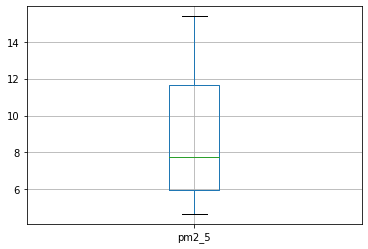

In [16]:
df_point.boxplot()

In [17]:
df_point=df_point.resample('1H').mean()

In [18]:
df_lag=pd.concat([df_point,df_point.shift(1),df_point.shift(2),
  df_point.shift(3),df_point.shift(4),df_point.shift(5),
  df_point.shift(6),df_point.shift(7),df_point.shift(8),
  df_point.shift(9),df_point.shift(10),df_point.shift(11),
  df_point.shift(12),df_point,df_point.shift(13),df_point.shift(14),
  df_point.shift(15),df_point.shift(16),df_point.shift(17),
  df_point.shift(18),df_point.shift(19),df_point.shift(20),df_point.shift(21),
  df_point.shift(22),df_point.shift(23),df_point.shift(24)],axis=1)
df_lag.columns=['pm2_5','Lag1','Lag2','Lag3','Lag4','Lag5','Lag6','Lag7','Lag8','Lag9',
'Lag10','Lag11','Lag12','Lag13','Lag14','Lag15','Lag16','Lag17','Lag18','Lag19','Lag20',
'Lag21','Lag22','Lag23','Lag24','Lag25']



In [19]:
df_lag

,pm2_5,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag16,Lag17,Lag18,Lag19,Lag20,Lag21,Lag22,Lag23,Lag24,Lag25
fecha,,,,,,,,,,,,,,,,,,,,,
2022-06-24 15:00:00,15.380000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 16:00:00,14.704000,15.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 17:00:00,12.730000,14.704,15.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 18:00:00,9.328000,12.730,14.704,15.380,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 19:00:00,7.100000,9.328,12.730,14.704,15.380,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 20:00:00,5.800000,7.100,9.328,12.730,14.704,15.380,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 21:00:00,5.038000,5.800,7.100,9.328,12.730,14.704,15.380,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 22:00:00,4.696000,5.038,5.800,7.100,9.328,12.730,14.704,15.380,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-24 23:00:00,4.762000,4.696,5.038,5.800,7.100,9.328,12.730,14.704,15.380,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_lag.dropna(inplace=True)

<AxesSubplot:xlabel='fecha'>

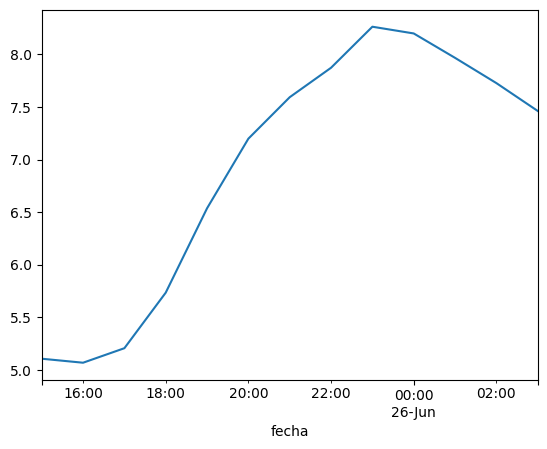

In [21]:
df_lag['pm2_5'].plot()

In [22]:
df_lag.shape

(13, 26)

In [23]:
df_lag

,pm2_5,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag16,Lag17,Lag18,Lag19,Lag20,Lag21,Lag22,Lag23,Lag24,Lag25
fecha,,,,,,,,,,,,,,,,,,,,,
2022-06-25 15:00:00,5.108000,5.318,5.804,6.415,7.170,8.484,9.864,11.055,12.146,13.108,...,8.665,4.762,4.696,5.038,5.800,7.100,9.328,12.730,14.704,15.380
2022-06-25 16:00:00,5.070000,5.108,5.318,5.804,6.415,7.170,8.484,9.864,11.055,12.146,...,12.540,8.665,4.762,4.696,5.038,5.800,7.100,9.328,12.730,14.704
2022-06-25 17:00:00,5.208000,5.070,5.108,5.318,5.804,6.415,7.170,8.484,9.864,11.055,...,12.558,12.540,8.665,4.762,4.696,5.038,5.800,7.100,9.328,12.730
2022-06-25 18:00:00,5.736000,5.208,5.070,5.108,5.318,5.804,6.415,7.170,8.484,9.864,...,12.650,12.558,12.540,8.665,4.762,4.696,5.038,5.800,7.100,9.328
2022-06-25 19:00:00,6.538000,5.736,5.208,5.070,5.108,5.318,5.804,6.415,7.170,8.484,...,12.955,12.650,12.558,12.540,8.665,4.762,4.696,5.038,5.800,7.100
2022-06-25 20:00:00,7.200000,6.538,5.736,5.208,5.070,5.108,5.318,5.804,6.415,7.170,...,13.300,12.955,12.650,12.558,12.540,8.665,4.762,4.696,5.038,5.800
2022-06-25 21:00:00,7.594000,7.200,6.538,5.736,5.208,5.070,5.108,5.318,5.804,6.415,...,13.108,13.300,12.955,12.650,12.558,12.540,8.665,4.762,4.696,5.038
2022-06-25 22:00:00,7.874000,7.594,7.200,6.538,5.736,5.208,5.070,5.108,5.318,5.804,...,12.146,13.108,13.300,12.955,12.650,12.558,12.540,8.665,4.762,4.696
2022-06-25 23:00:00,8.264000,7.874,7.594,7.200,6.538,5.736,5.208,5.070,5.108,5.318,...,11.055,12.146,13.108,13.300,12.955,12.650,12.558,12.540,8.665,4.762


In [24]:
cont=0
while (cont < largo):
        df_point=df_group.get_group(point_locations[cont])[['fecha','pm2_5']].sort_values(by="fecha")
        #print(point_locations[cont])
        df_point.set_index('fecha',drop=True,inplace=True)
        df_point=df_point.resample('1H').mean()
        df_lag=pd.concat([df_point,df_point.shift(1),df_point.shift(2),
                 df_point.shift(3),df_point.shift(4),df_point.shift(5),
                 df_point.shift(6),df_point.shift(7),df_point.shift(8),
                 df_point.shift(9),df_point.shift(10),df_point.shift(11),
                 df_point.shift(12),df_point,df_point.shift(13),df_point.shift(14),
                 df_point.shift(15),df_point.shift(16),df_point.shift(17),
                 df_point.shift(18),df_point.shift(19),df_point.shift(20),df_point.shift(21),
                df_point.shift(22),df_point.shift(23),df_point.shift(24)],axis=1)
        df_lag.columns=['pm2_5','Lag1','Lag2','Lag3','Lag4','Lag5','Lag6','Lag7','Lag8','Lag9',
                'Lag10','Lag11','Lag12','Lag13','Lag14','Lag15','Lag16','Lag17','Lag18','Lag19','Lag20',
                'Lag21','Lag22','Lag23','Lag24','Lag25']
        df_lag.dropna(inplace=True)
                
        data_test = df_lag 
        data_test = common.ListDataset([{'start': df.index[0],'target': df['pm2_5']}],freq='1H')
        
        cont=cont+1
        

In [25]:
#esto lo tenia el otro codigo
data_test = df_lag 
data_test = common.ListDataset([{'start': df.index[0],'target': df['pm2_5']}],freq='1H')

<AxesSubplot:>

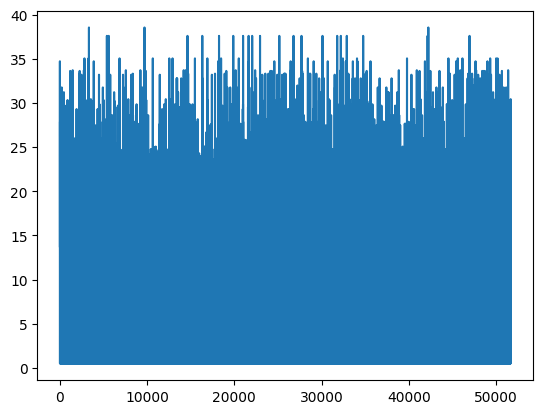

In [26]:
df['pm2_5'].plot()

In [27]:
predictor = Predictor.deserialize(Path('trained_model'))

forecast_it,ts_it=make_evaluation_predictions(dataset=data_test,predictor=predictor,num_samples=100)


TypeError: __init__() got an unexpected keyword argument 'freq'

In [ ]:
forecast_it,ts_it=make_evaluation_predictions(dataset=data_test,predictor=predictor,num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)